#### ML Modeling

In [3]:
import pandas as pd

# 사용할 모델
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from freeman.plt_setting import plt_settings
from freeman.evaluation import regression_evaluation, f_importances, plot_actual_pred
from freeman.aiddd.data_manager import read_data

plt_settings()

In [4]:
df_X = read_data('2a-sub-scaled-X', process_seq='4th')
df_y = read_data('2a-sub-y', process_seq='4th')

In [5]:
training_columns = df_X.columns

X_train, X_test, y_train, y_test = \
    train_test_split(df_X, df_y, test_size=0.2)
    
X_test_copy = X_test.copy()

In [6]:
SEED = 123
ml_models = {
    'LIN': LinearRegression(),
    'LASSO': Lasso(),
    'RIDGE': Ridge(),
    'KNR': KNeighborsRegressor(),
    'DTR': DecisionTreeRegressor(),
    'RFR': RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=SEED),
    'GBR': GradientBoostingRegressor(),
    'EN': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=SEED),
    'XGR': XGBRegressor(eta=0.01, n_estimators=100, n_jobs=-1),
}

In [7]:
def diff_ytest_pred(model_key, test, pred):
    test = test['total_cons_cost'].values.tolist()
    pred = pred.tolist()
    if isinstance(pred[0], list):
        pred = [item for sub in pred for item in sub]
    max_test = max(test)
    loop_size = len(test)
    result_mape = []
    result_max_mape = []
    for idx in range(loop_size):
        new_mape = abs((test[idx] - pred[idx])/test[idx])*100
        new_max_mape = abs((test[idx] - pred[idx])/(test[idx]+max_test))*100
        result_mape.append(new_mape)
        result_max_mape.append(new_max_mape)
    X_test_copy[f'{model_key}_mape'] = result_mape
    X_test_copy[f'{model_key}_max_mape'] = result_max_mape

In [8]:
def model_fit_and_evaluation(model_key, display_start=0, display_size=50):
    model = ml_models[model_key]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(f'Evaluation: {model_key}')
    evaluation_value = regression_evaluation(y_test, predictions)
    evaluation_values.append(evaluation_value)
    model_names.append(model_key)
    diff_ytest_pred(model_key, y_test, predictions)
    try:
        f_importances(model, training_columns, model_key)
    except AttributeError as e:
        print(f'`{model_key}` object has no attribute `feature_importances_`')
    plot_actual_pred(
        y_test[display_start:display_start+display_size],
        predictions[display_start:display_start+display_size],
        model_key
    )

Evaluation: LIN
R2_SCORE: 0.671701, MAPE: 18.517384, MSE: 2885751956171.283203, RMSE: 1698750.115871, MAE: 833402.076943
`LIN` object has no attribute `feature_importances_`


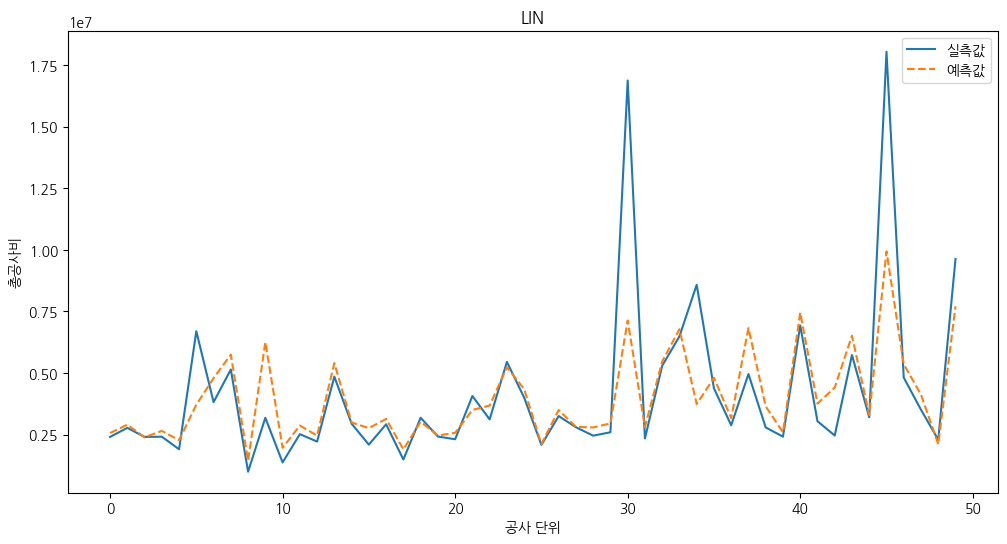

/home/freeman/anaconda3/envs/t213p310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.387e+16, tolerance: 8.754e+12
  model = cd_fast.enet_coordinate_descent(


Evaluation: LASSO
R2_SCORE: 0.671696, MAPE: 18.517255, MSE: 2885796960061.965820, RMSE: 1698763.361997, MAE: 833388.876813
`LASSO` object has no attribute `feature_importances_`


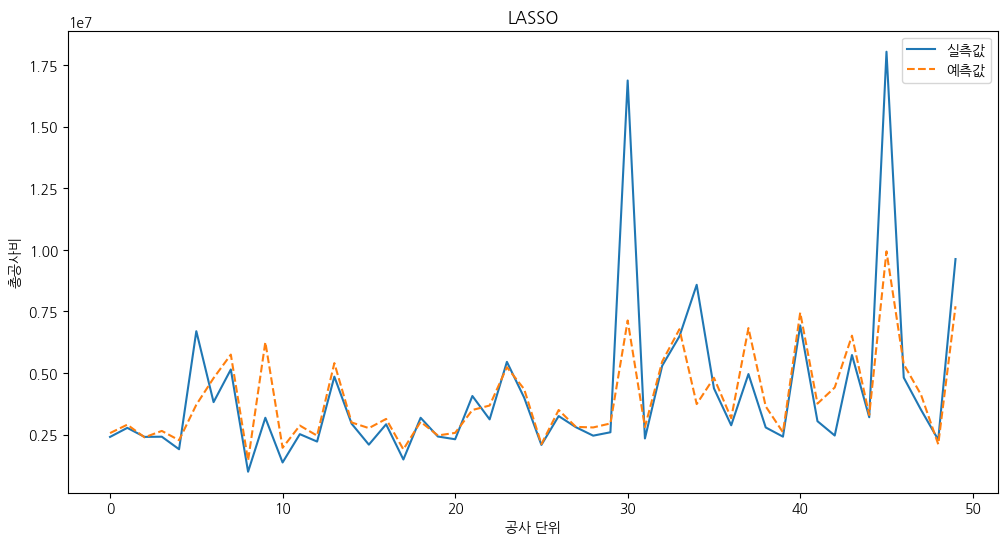

Evaluation: RIDGE
R2_SCORE: 0.671788, MAPE: 18.516892, MSE: 2884990372914.124023, RMSE: 1698525.941196, MAE: 833325.089408
`RIDGE` object has no attribute `feature_importances_`


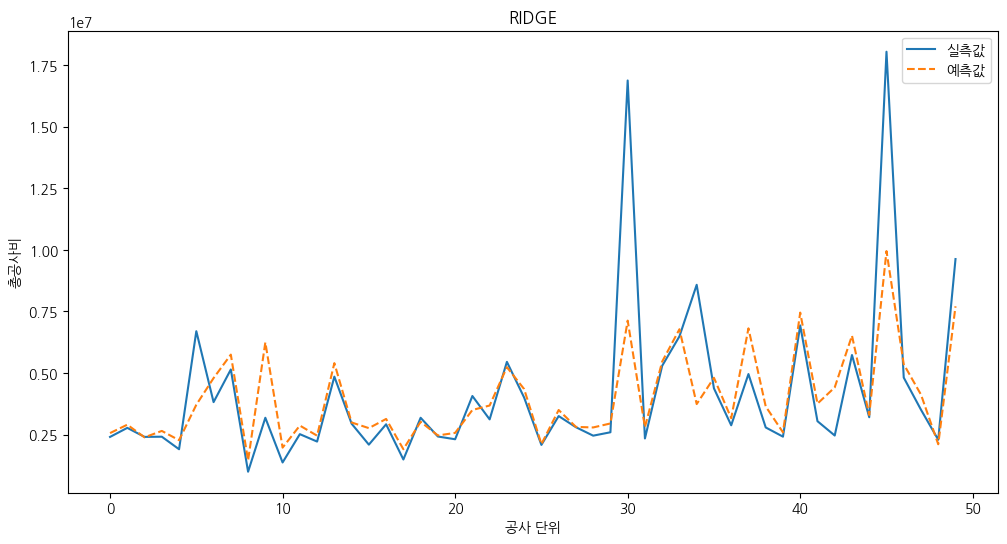

Evaluation: KNR
R2_SCORE: 0.609047, MAPE: 18.043882, MSE: 3436486701496.302246, RMSE: 1853776.335348, MAE: 857454.487484
`KNR` object has no attribute `feature_importances_`


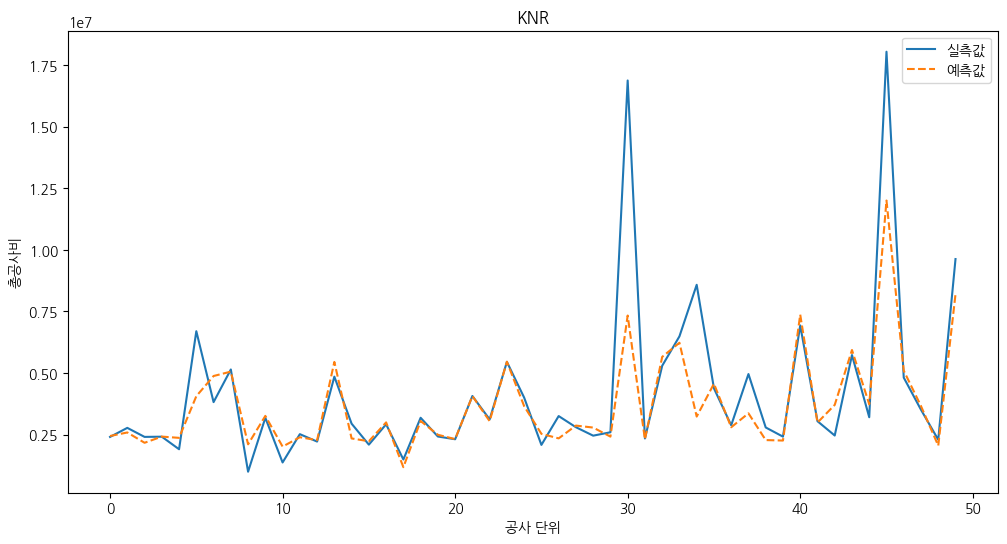

Evaluation: DTR
R2_SCORE: 0.240876, MAPE: 24.703216, MSE: 6672721339121.319336, RMSE: 2583161.113659, MAE: 1117834.234080


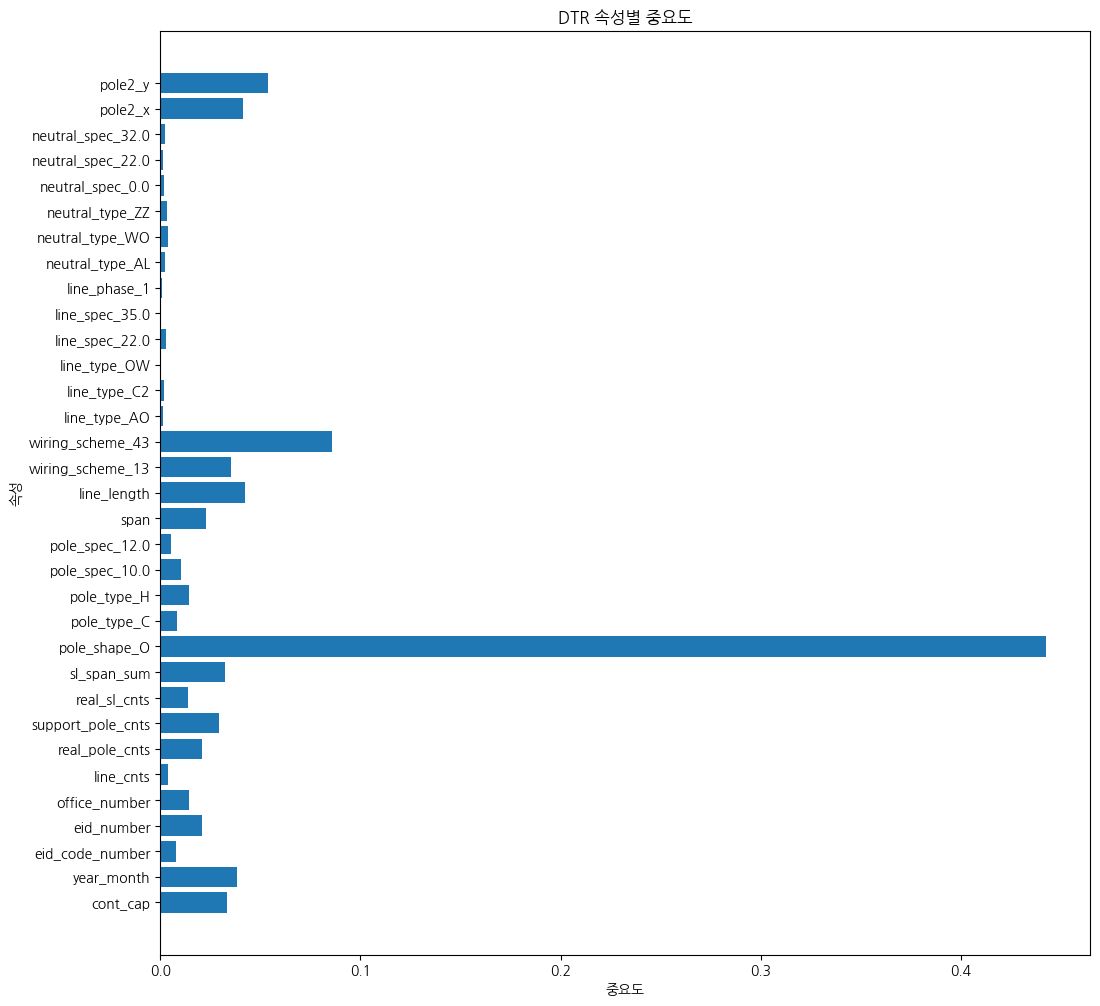

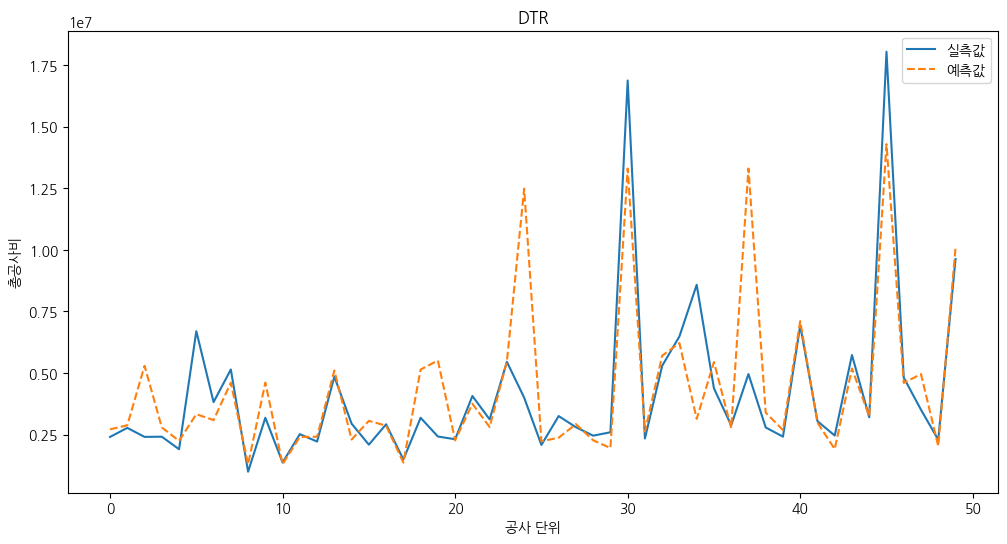

/home/freeman/anaconda3/envs/t213p310/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Evaluation: RFR
R2_SCORE: 0.661108, MAPE: 17.801446, MSE: 2978872524174.365723, RMSE: 1725941.054664, MAE: 820833.871660


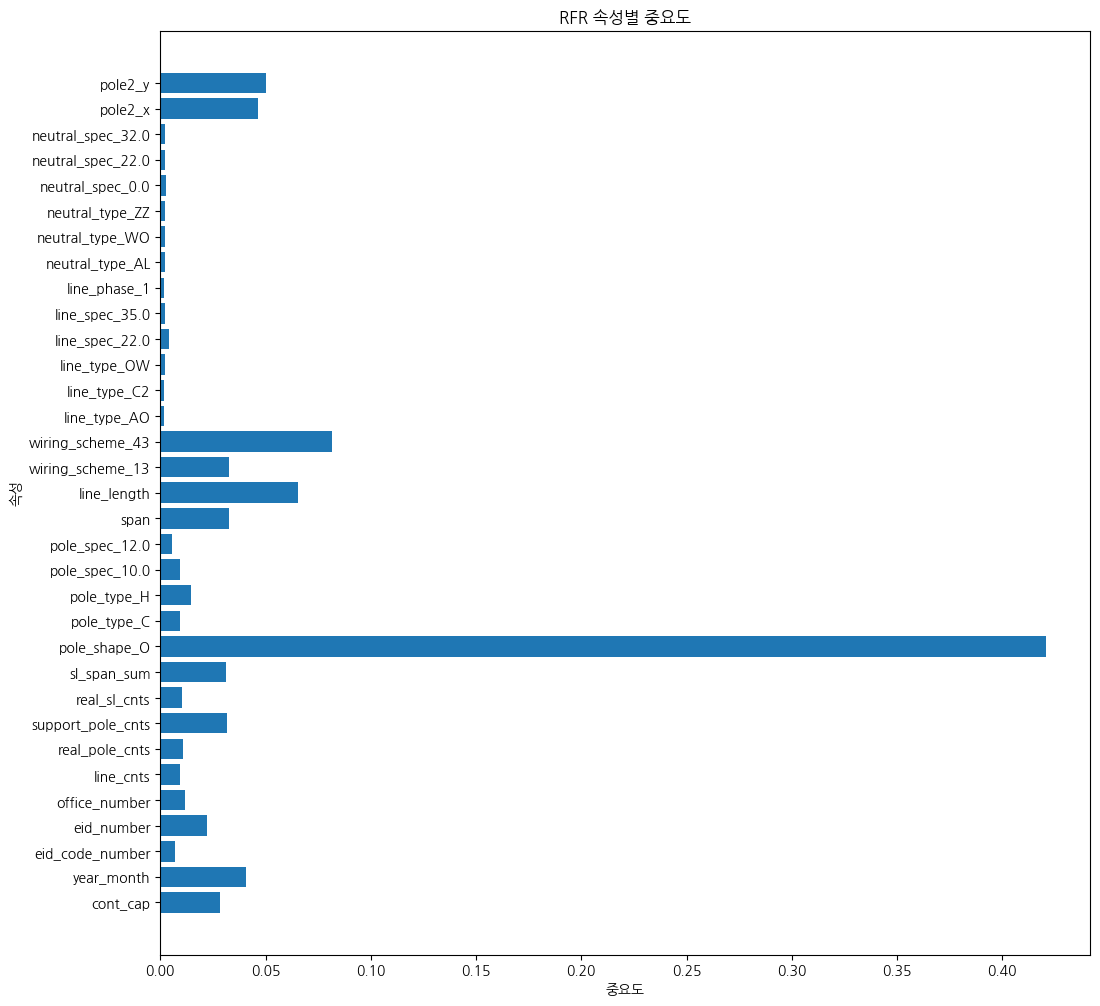

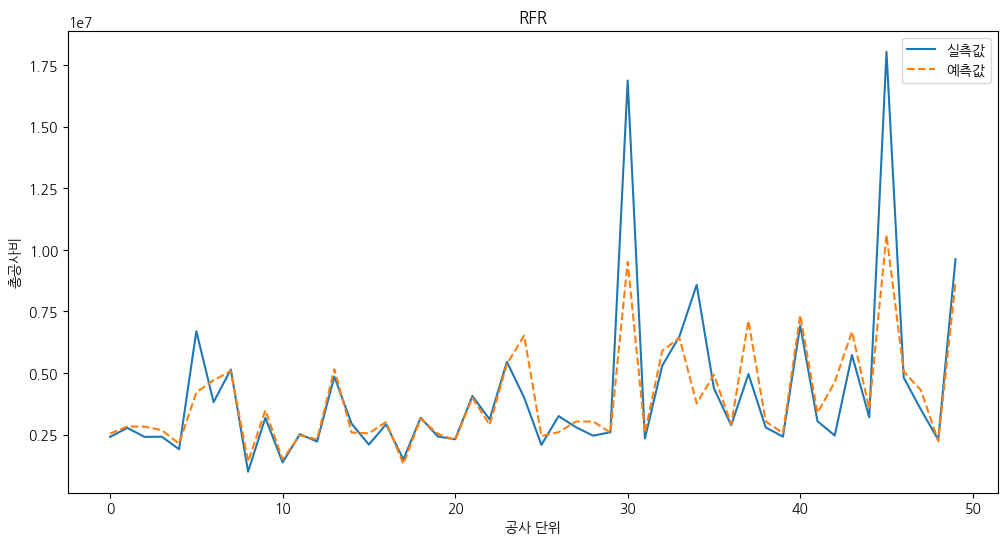

/home/freeman/anaconda3/envs/t213p310/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluation: GBR
R2_SCORE: 0.672131, MAPE: 17.318671, MSE: 2881973144668.766602, RMSE: 1697637.518633, MAE: 802274.022230


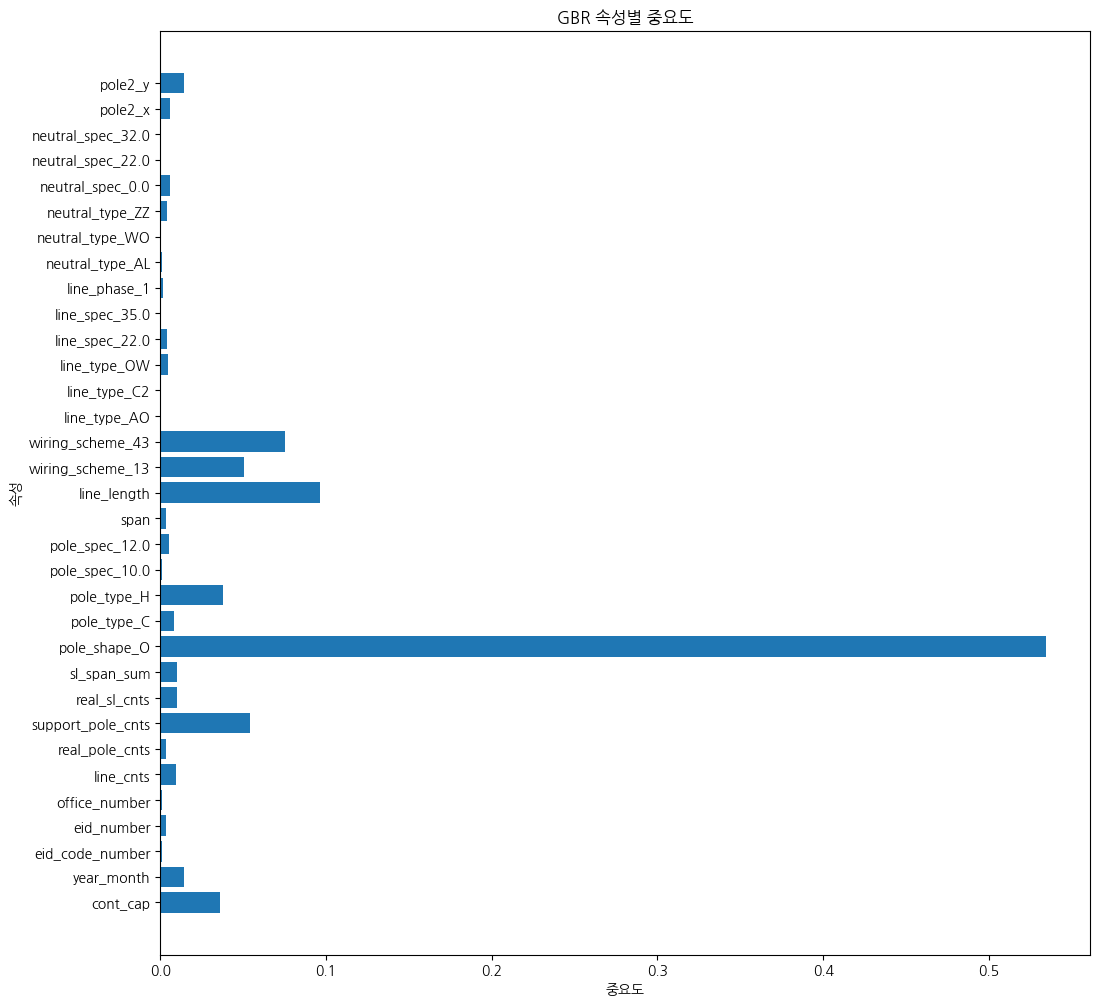

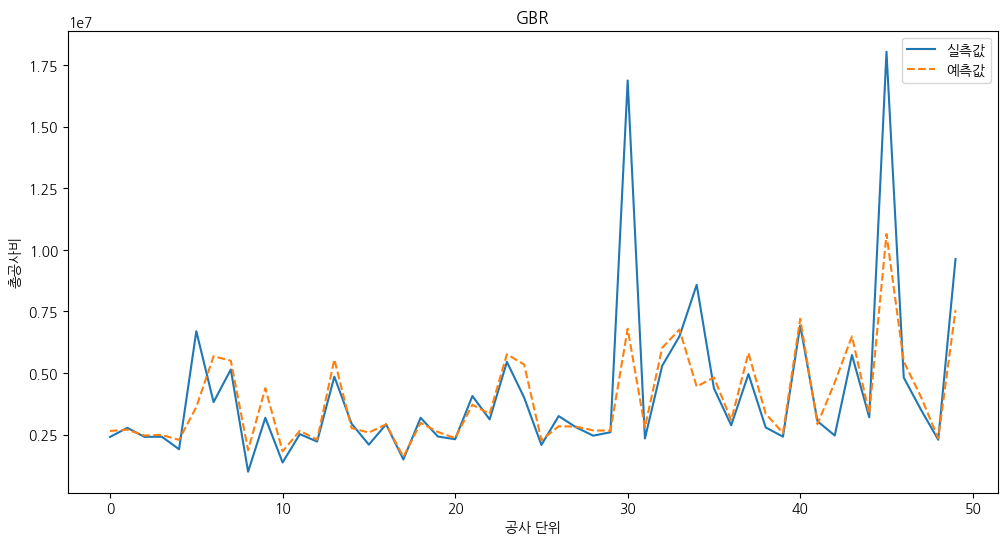

Evaluation: EN
R2_SCORE: 0.669172, MAPE: 18.860540, MSE: 2907985650427.128418, RMSE: 1705281.692398, MAE: 836682.097347
`EN` object has no attribute `feature_importances_`


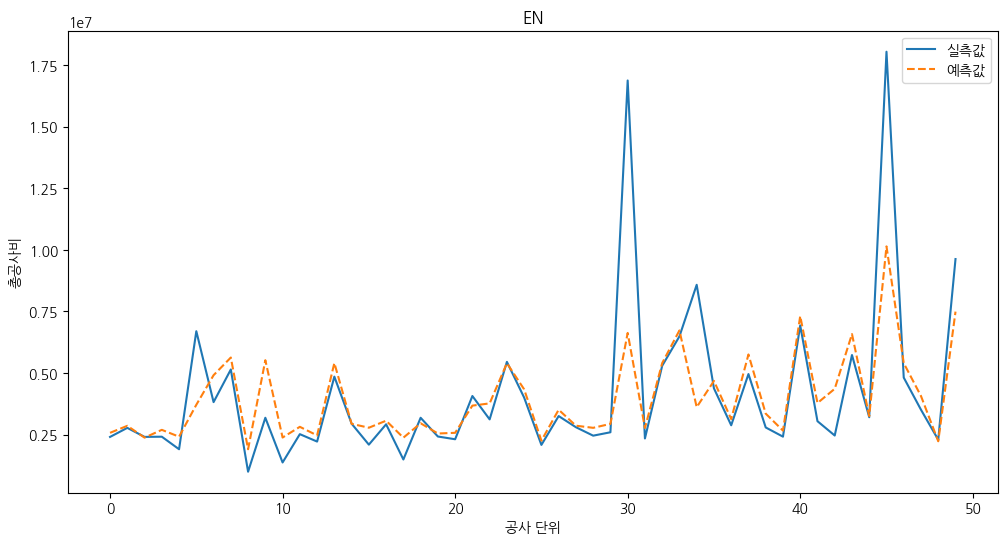

Evaluation: XGR
R2_SCORE: 0.294996, MAPE: 32.994615, MSE: 6197003497385.891602, RMSE: 2489378.134673, MAE: 1547625.490311


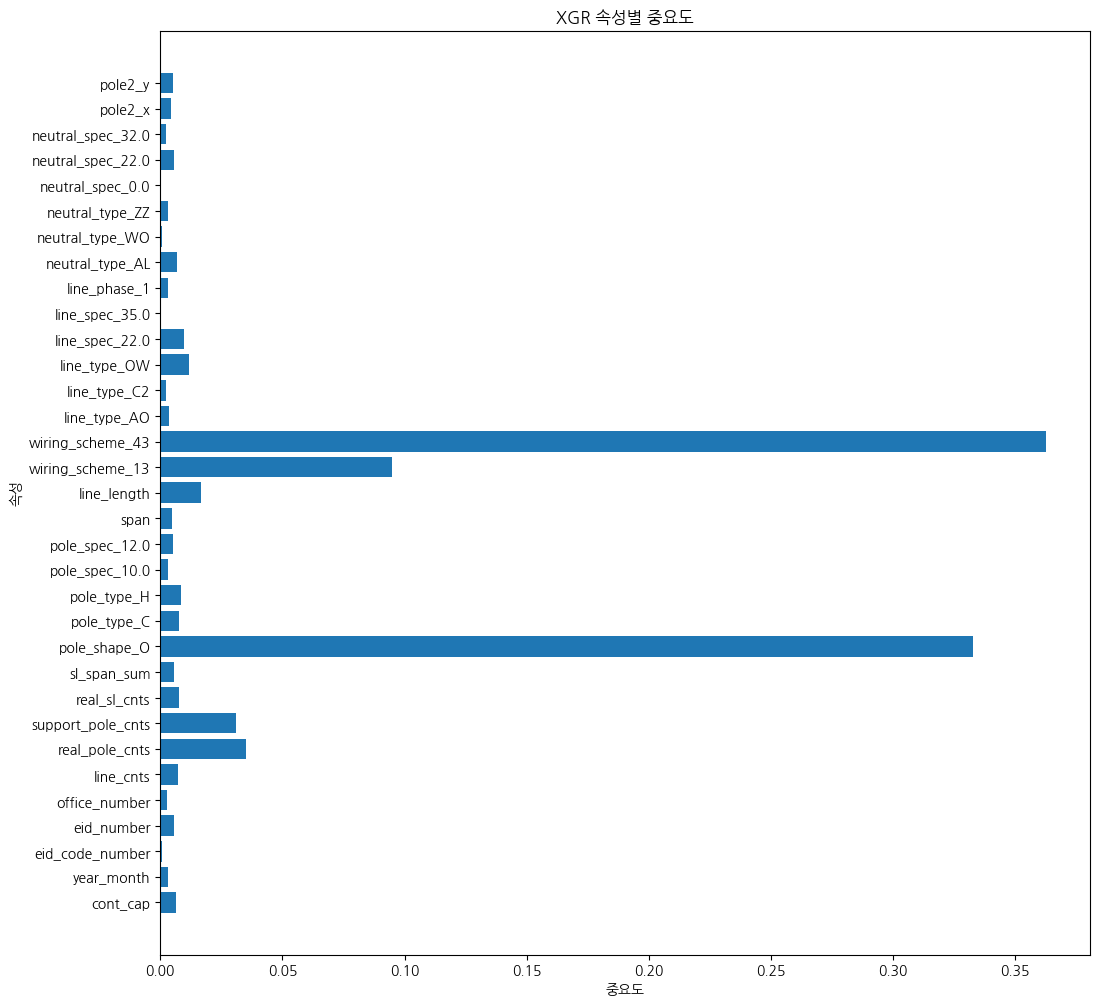

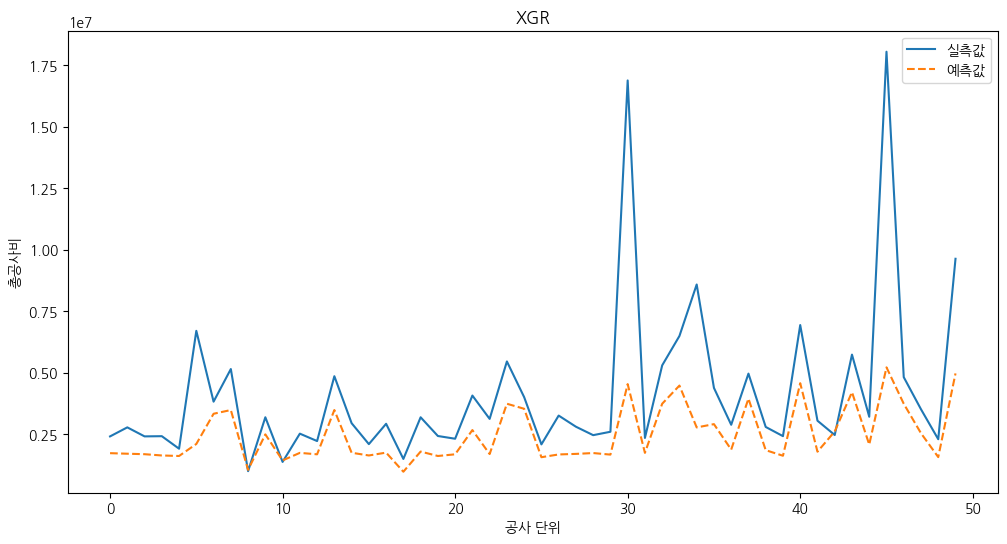

In [9]:
evaluation_values = []
model_names = []
column_names = ['r2score', 'mape', 'mse', 'rmse', 'mae']
for _model_key in ml_models.keys():
    model_fit_and_evaluation(_model_key, display_start=50, display_size=50)
    
df_evaluation = pd.DataFrame(
    evaluation_values, columns=column_names, index=model_names
)

In [10]:
df_evaluation

,r2score,mape,mse,rmse,mae
LIN,0.671701,0.185174,2.885752e+12,1.698750e+06,8.334021e+05
LASSO,0.671696,0.185173,2.885797e+12,1.698763e+06,8.333889e+05
RIDGE,0.671788,0.185169,2.884990e+12,1.698526e+06,8.333251e+05
KNR,0.609047,0.180439,3.436487e+12,1.853776e+06,8.574545e+05
DTR,0.240876,0.247032,6.672721e+12,2.583161e+06,1.117834e+06
RFR,0.661108,0.178014,2.978873e+12,1.725941e+06,8.208339e+05
GBR,0.672131,0.173187,2.881973e+12,1.697638e+06,8.022740e+05
EN,0.669172,0.188605,2.907986e+12,1.705282e+06,8.366821e+05
XGR,0.294996,0.329946,6.197003e+12,2.489378e+06,1.547625e+06
